# Wind Power Forecasting using Weather data 


In [56]:
#Libraries Used
import pandas as pd
import numpy as np

#WindPowerlib used to calculate the Wind Power Curve using a real Wind Turbine Data
__copyright__ = "Copyright oemof developer group"
__license__ = "GPLv3"
import os
from windpowerlib.modelchain import ModelChain
from windpowerlib.wind_turbine import WindTurbine
from windpowerlib import wind_turbine as wt
from windpowerlib import wind_turbine

#Debugging Use
#import logging
#logging.getLogger().setLevel(logging.DEBUG)

#Hide Warnings
import warnings
warnings.filterwarnings('ignore')


### Reading Weather Data


In [53]:
#Reading WeatherDataOneMin
df=pd.read_csv('WeatherDataOneMin.csv',sep=',',index_col=0,header=[1,2],date_parser=lambda idx: pd.to_datetime(idx, utc=True))
#Drop NaN Values
df_full=df.dropna(axis='columns')
#Change columns names
df_full.columns=['Wind Speed', 'Wind Direction', 'Solar Radiation',
       'Air Temp', 'Relative Humidity', 'Rain fall', 'Horizontal Visibility',
       'Barametric Pressure']

## 1.Data preprocessing
This step includes removing columns we do not need, check missing values, convert data types,aggregate by date and so on.

In [57]:
#Take only the needed columns
df_full_power=df_full[['Barametric Pressure','Air Temp','Wind Speed']]
df_full_power.index = pd.to_datetime(df_full_power.index)
columns=df_full_power.columns
#Convert Columns data type to Float
#Change Columns data type to Numeric 
df_full_power[columns] = df_full_power[columns].apply(pd.to_numeric, errors='coerce')
print(df_full_power.isnull().sum())


Barametric Pressure     1
Air Temp                0
Wind Speed             13
dtype: int64


### Data Resampling
This step includes resampling data into daily data and add Roughness value 

In [58]:
#Data Resampling to Hours formant instead of Mins
df_full_power_daily = df_full_power.resample('D').mean()

#Add the roughness constant into the dataframe
df_full_power_daily["roughness_length"]=0.4  # Constant for areas like the Bussiness park

#Adding the Height of Turbine as Second Header
cols = list(zip(["pressure","temperature","wind_speed","roughness_length"], [0,2,10,0,10,80]))
df_full_power_daily.columns=pd.MultiIndex.from_tuples(cols)
print(df_full_power_daily.isnull().sum())
df_full_power_daily.head(5)

pressure          0     54
temperature       2     54
wind_speed        10    54
roughness_length  0      0
dtype: int64


,pressure,temperature,wind_speed,roughness_length
,0,2,10,0
2018-01-25 00:00:00+00:00,995.052494,5.274912,3.890930,0.4
2018-01-26 00:00:00+00:00,996.538384,2.795220,5.318654,0.4
2018-01-27 00:00:00+00:00,995.602468,4.068116,1.846597,0.4
2018-01-28 00:00:00+00:00,999.436991,6.038955,1.334939,0.4
2018-01-29 00:00:00+00:00,997.820237,5.643804,0.931571,0.4


#### Convert Temprature to Kelvin 
we need this step to make the temprature data compatible with Wind Turbine input data 

In [59]:
#Convert the Temprature into Kelvin 
df_full_power_daily[("temperature",2)]=df_full_power_daily[("temperature",2)]+273.15
df_full_power_daily[("temperature",2)].head(5)

2018-01-25 00:00:00+00:00    278.424912
2018-01-26 00:00:00+00:00    275.945220
2018-01-27 00:00:00+00:00    277.218116
2018-01-28 00:00:00+00:00    279.188955
2018-01-29 00:00:00+00:00    278.793804
Freq: D, Name: (temperature, 2), dtype: float64

In [60]:
#Check Null Values
print(df_full_power_daily.isnull().sum())

pressure          0     54
temperature       2     54
wind_speed        10    54
roughness_length  0      0
dtype: int64


## Impute NAN values
I used time interpolation to impute NAN values ; Which ‘time’ method: Works on daily and higher resolution data to interpolate given length of interval.

In [61]:
#Impute the missing values with linear interpolation
df_full_power_daily[('pressure',0)].interpolate(method='time', inplace=True)
df_full_power_daily[('temperature',2)].interpolate(method='time', inplace=True)
df_full_power_daily[('wind_speed',10)].interpolate(method='time', inplace=True)

print(df_full_power_daily.isnull().sum())
df_full_power_daily.head(5)

pressure          0     0
temperature       2     0
wind_speed        10    0
roughness_length  0     0
dtype: int64


,pressure,temperature,wind_speed,roughness_length
,0,2,10,0
2018-01-25 00:00:00+00:00,995.052494,278.424912,3.890930,0.4
2018-01-26 00:00:00+00:00,996.538384,275.945220,5.318654,0.4
2018-01-27 00:00:00+00:00,995.602468,277.218116,1.846597,0.4
2018-01-28 00:00:00+00:00,999.436991,279.188955,1.334939,0.4
2018-01-29 00:00:00+00:00,997.820237,278.793804,0.931571,0.4


# 2.Load the wind turbine data 
this step includes loading wind turbine real data using The windpower library,to calculate the estimated generated power using specific turbine which is applied on the weather station data

The windpowerlib is a library that provides a set of functions and classes to calculate the power output of wind turbines. It was originally part of the feedinlib (windpower and photovoltaic) but was taken out to build up a community concentrating on wind power models.

https://windpowerlib.readthedocs.io/en/latest/getting_started.html

In [62]:
#Load the Wind Turbine Data from oedb data base
data=wind_turbine.load_turbine_data_from_oedb(schema="supply",table="wind_turbine_library")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): oep.iks.cs.ovgu.de:80
DEBUG:urllib3.connectionpool:http://oep.iks.cs.ovgu.de:80 "GET //api/v0/schema/supply/tables/wind_turbine_library/rows/ HTTP/1.1" 301 425
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): openenergy-platform.org:443
DEBUG:urllib3.connectionpool:https://openenergy-platform.org:443 "GET /api/v0/schema/supply/tables/wind_turbine_library/rows/ HTTP/1.1" 200 None


In [63]:
data.head()

,calculated,has_cp_curve,has_ct_curve,has_power_curve,hub_height,id,manufacturer,max_speed_drive,name,nominal_power,...,rotor_area,rotor_diameter,source,thrust_coefficient_curve_values,thrust_coefficient_curve_wind_speeds,turbine_id,turbine_type,turbine_type_v2,wind_class_iec,wind_zone_dibt
0,None,False,False,False,None,80,Adwen/Areva,14,AD 5-135,5050,...,14312,135,https://www.wind-turbine-models.com/turbines/1...,None,None,86,AD135/5050,AD-135_5050,IEC I (GL-TK 1 & GL-TK S),None
1,None,False,False,False,101;120.9;149;169,111,GE Wind,None,GE 4.8-158,4800,...,19604,158,https://www.gerenewableenergy.com/wind-energy/...,None,None,120,GE158/4800,GE-158_4800,None,None
2,True,False,False,False,85;110;131;134;155,113,GE Wind,None,GE 3.4-137,3400,...,14739,137,https://www.wind-turbine-models.com/turbines/1...,None,None,122,GE137/3400,GE-137_3400,None,None
3,None,False,False,False,85;110;131.4;164.5,112,GE Wind,None,GE 3.6-137,3600,...,14739,137,https://www.wind-turbine-models.com/turbines/1...,None,None,121,GE137/3600,GE-137_3600,IIIb,None
4,None,False,False,False,None,129,Eno,None,ENO 92,2200,...,6647,92,https://www.wind-turbine-models.com/turbines/6...,None,None,140,ENO92/2200,ENO-92_2200,None,None


### Using Enercon_e126 turbine 

The Enercon E-126 is an onshore wind turbine model manufactured by the German company Enercon. With a hub height of 135 m (443 ft), rotor diameter of 126 m (413 ft) and a total height of 198 m (650 ft), the turbine can generate up to 7.58 megawatts of power
https://en.wikipedia.org/wiki/Enercon_E-126

In [64]:
# specification of wind turbine where power curve is provided in the
# oedb turbine library
#Use a specific Turbine "E-126/4200" 
enercon_e126 = {
'turbine_type': 'E-126/4200', # turbine type as in oedb turbine library
'hub_height': 135 # in m
}
# initialize WindTurbine object
e126 = WindTurbine(**enercon_e126)

In [65]:
e126

Wind turbine: E-126/4200 ['nominal power=4200000.0 W', 'hub height=135 m', 'rotor diameter=127.0 m', 'power_coefficient_curve=True', 'power_curve=True']

### Initialize wind turbine example 

In [66]:
 # specification of own wind turbine (Note: power curve values and
# nominal power have to be in Watt)
my_turbine = {
'nominal_power': 3e6, # in W
'hub_height': 105, # in m
'power_curve': pd.DataFrame(
data={'value': [p * 1000 for p in [
0.0, 26.0, 180.0, 1500.0, 3000.0, 3000.0]], # in W
'wind_speed': [0.0, 3.0, 5.0, 10.0, 15.0, 25.0]}) # in m/s
}
# initialize WindTurbine object
my_turbine = WindTurbine(**my_turbine)

In [67]:
my_turbine

Wind turbine: ['nominal power=3000000.0 W', 'hub height=105 m', 'power_coefficient_curve=False', 'power_curve=True']

### Using the ModelChain to calculate turbine power output

The ModelChain is a class that provides all necessary steps to calculate the power output of a wind turbine. When calling the 'run_model' method, first the wind speed and density (if necessary) at hub height are calculated and then used to calculate the power output. 

In [68]:
# power output calculation for my_turbine
# initialize ModelChain with default parameters and use run_model
# method to calculate power output
mc_my_turbine = ModelChain(my_turbine).run_model(df_full_power_daily)
# write power output time series to WindTurbine object
my_turbine.power_output = mc_my_turbine.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [69]:
#df_full_hourly.isna().count()
my_turbine.power_output.head(5)

2018-01-25 00:00:00+00:00    6.375748e+05
2018-01-26 00:00:00+00:00    1.289832e+06
2018-01-27 00:00:00+00:00    4.105571e+04
2018-01-28 00:00:00+00:00    2.002093e+04
2018-01-29 00:00:00+00:00    1.397136e+04
Freq: D, Name: feedin_power_plant, dtype: float64

### Calculate the power output for the e126 turbine 

In [70]:
# power output calculation for e126

# own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model': 'power_curve',    # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
                 # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None

In [71]:
modelchain_data

{'wind_speed_model': 'logarithmic',
 'density_model': 'ideal_gas',
 'temperature_model': 'linear_gradient',
 'power_output_model': 'power_curve',
 'obstacle_height': 0,
 'hellman_exp': None}

In [72]:
# initialize ModelChain with own specifications and use run_model method to
# calculate power output
#mc_my_turbine = ModelChain(my_turbine).run_model(weather)
mc_e126 = ModelChain(e126,**modelchain_data).run_model(df_full_power_daily)
# write power output time series to WindTurbine object
e126.power_output = mc_e126.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [73]:
e126.power_output.head(5)

2018-01-25 00:00:00+00:00    1.221844e+06
2018-01-26 00:00:00+00:00    2.864840e+06
2018-01-27 00:00:00+00:00    1.011422e+05
2018-01-28 00:00:00+00:00    2.403128e+04
2018-01-29 00:00:00+00:00    0.000000e+00
Freq: D, Name: feedin_power_plant, dtype: float64

In [74]:
e126.power_output.isna().sum()

0

### Plotting the Power generated By my_turbine and e126 Turbine

In [75]:
# try to import matplotlib
logging.getLogger().setLevel(logging.WARNING)
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

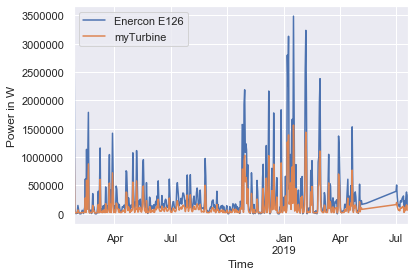

In [76]:
# plot turbine power output
if plt:
    e126.power_output.plot(legend=True, label='Enercon E126')
    my_turbine.power_output.plot(legend=True, label='myTurbine')
    #dummy_turbine.power_output.plot(legend=True, label='dummyTurbine')
    plt.xlabel('Time')
    plt.ylabel('Power in W')
    plt.show()

### Plotting Power Curve
We can measure that E126 turbine can generate power better than my_turbine

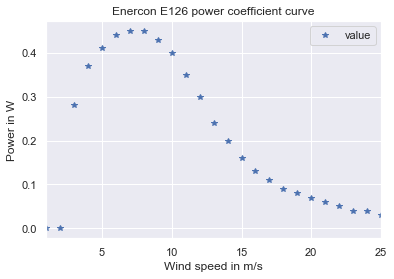

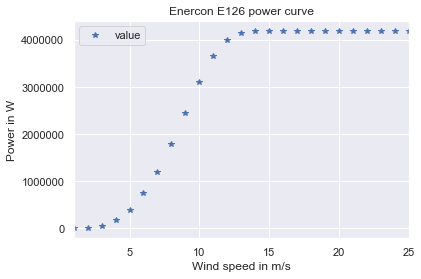

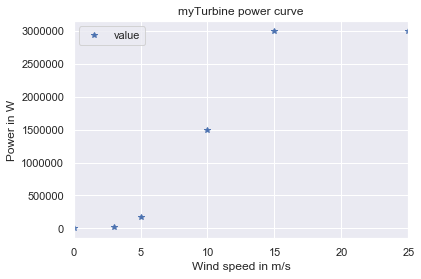

In [77]:
# plot power (coefficient) curves
if plt:
    if e126.power_coefficient_curve is not None:
        e126.power_coefficient_curve.plot(
            x='wind_speed', y='value', style='*',
            title='Enercon E126 power coefficient curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()
    if e126.power_curve is not None:
        e126.power_curve.plot(x='wind_speed', y='value', style='*',
                              title='Enercon E126 power curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()
    if my_turbine.power_coefficient_curve is not None:
        my_turbine.power_coefficient_curve.plot(
            x='wind_speed', y='value', style='*',
            title='myTurbine power coefficient curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()
    if my_turbine.power_curve is not None:
        my_turbine.power_curve.plot(x='wind_speed', y='value', style='*',
                                    title='myTurbine power curve')
        plt.xlabel('Wind speed in m/s')
        plt.ylabel('Power in W')
        plt.show()

plots above shows the power curve for each turbine and its obvious that e126 better than the imaginary "my_turbine"

In [78]:
df_full_power_daily.head(5)

,pressure,temperature,wind_speed,roughness_length
,0,2,10,0
2018-01-25 00:00:00+00:00,995.052494,278.424912,3.890930,0.4
2018-01-26 00:00:00+00:00,996.538384,275.945220,5.318654,0.4
2018-01-27 00:00:00+00:00,995.602468,277.218116,1.846597,0.4
2018-01-28 00:00:00+00:00,999.436991,279.188955,1.334939,0.4
2018-01-29 00:00:00+00:00,997.820237,278.793804,0.931571,0.4


##### Now we will use the E126 power output as as the estimated power for forecasting   

In [79]:
#add e126 power output into the data frame 
df_full_power_daily["Power"]=e126.power_output

In [80]:
print(df_full_power_daily.isnull().sum())

pressure          0     0
temperature       2     0
wind_speed        10    0
roughness_length  0     0
Power                   0
dtype: int64


##### Taking only the wind speed and power

In [81]:
Windpower=df_full_power_daily[['wind_speed', 'Power']]
Windpower.set_axis(['wind_speed', 'Power'], axis=1, inplace=True)
#dff=dff.resample('D').mean()
Windpower.head(5)

,wind_speed,Power
2018-01-25 00:00:00+00:00,3.890930,1.221844e+06
2018-01-26 00:00:00+00:00,5.318654,2.864840e+06
2018-01-27 00:00:00+00:00,1.846597,1.011422e+05
2018-01-28 00:00:00+00:00,1.334939,2.403128e+04
2018-01-29 00:00:00+00:00,0.931571,0.000000e+00


#### Convert index format to be used in the forecasting 

In [82]:
Windpower.index = pd.to_datetime(Windpower.index, format = '%Y/%m/%d')
Windpower.index=Windpower.index.strftime('%Y-%m-%d')
Windpower.index = pd.to_datetime(Windpower.index)
Windpower.head(5)

,wind_speed,Power
2018-01-25,3.890930,1.221844e+06
2018-01-26,5.318654,2.864840e+06
2018-01-27,1.846597,1.011422e+05
2018-01-28,1.334939,2.403128e+04
2018-01-29,0.931571,0.000000e+00


### Convert the Generated power format to kilo watt  

In [83]:
windpower_kw=Windpower
windpower_kw.loc[:,'Power'] /= 1000 
power_kw=pd.DataFrame(Windpower["Power"])
windpower_kw.head(5)

,wind_speed,Power
2018-01-25,3.890930,1221.843541
2018-01-26,5.318654,2864.840047
2018-01-27,1.846597,101.142181
2018-01-28,1.334939,24.031280
2018-01-29,0.931571,0.000000


#### Plotting Powe and Wind spead

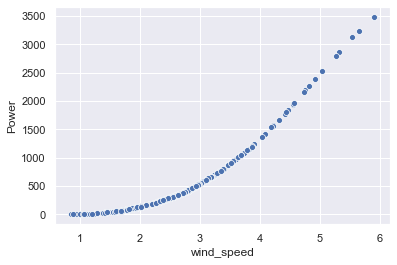

In [84]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime

ax = sns.scatterplot(x='wind_speed',y='Power',data=windpower_kw)

We can see the Linear correlation between the wind speed and power

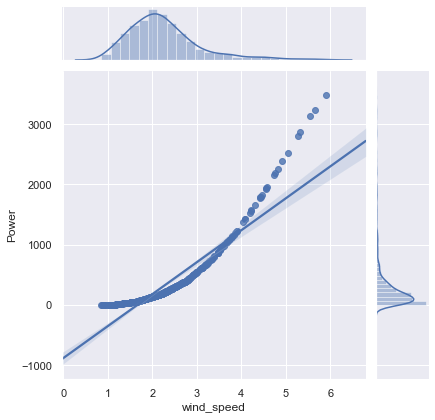

In [85]:
sns.jointplot(x='wind_speed', y='Power', data=windpower_kw, kind='reg')

We can interpret the relation between wind speed and power as Linear 

### Predicting the wind power generation using linear regression

To predict the wind generation, we construct the features matrix X_wind with wind speed feature, and the target Y_wind with estimated wind generation. Then, we implement the algorithm:

In [86]:
X_wind = windpower_kw[['wind_speed']]
y_wind = windpower_kw[['Power']]
y_wind.head(5)

,Power
2018-01-25,1221.843541
2018-01-26,2864.840047
2018-01-27,101.142181
2018-01-28,24.031280
2018-01-29,0.000000


##### We import LinearRegression from sklearn.linear_model, which implements the ordinary least squares linear regression.

In order to evaluate the performance of the algorithm, we divide the data using a procedure called cross-validation (CV for short). For the k-fold CV, the dataset is split into k smaller sets or ‘folds’, the model is trained in k-1 of those folds, and the resulting model is validated on the remaining part of the data. The performance measure provided by the CV is then the average of the performance measure computed in each experiment. In the code above, we use cross_val_score from sklearn.model_selection, with number of folds cv=3

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
scores_wind = cross_val_score(lr, X_wind, y_wind, cv=3)
print(scores_wind, "\naverage =", np.mean(scores_wind))

[0.78790121 0.84753214 0.81039944] 
average = 0.815277596675965


The first line above contains the three values of R² for each of the 3 folds in the cross validation procedure, whereas the second line is their average. We see that our linear model has an R² of approximately 0.82, which is quite good for such a simple model! We can make good predictions about the wind generation in Jordan in 2016 given only the wind velocity.

# 3 Visualizing Power  time series data

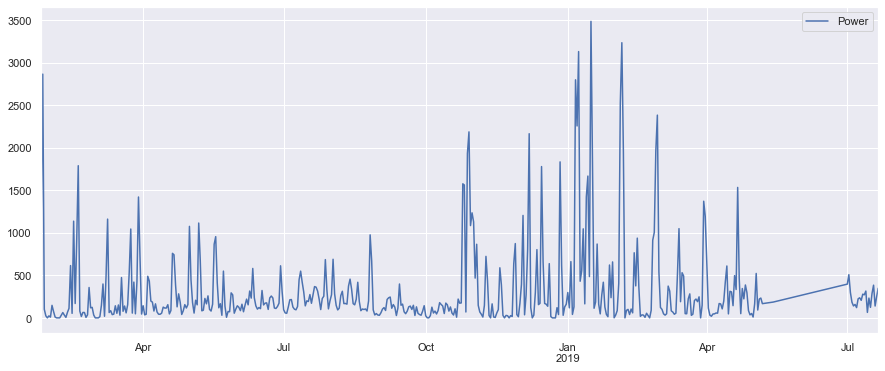

In [88]:
power_kw.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as power are always low in the summer and high at the beginning  of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct 
#### components: trend, seasonality, and noise

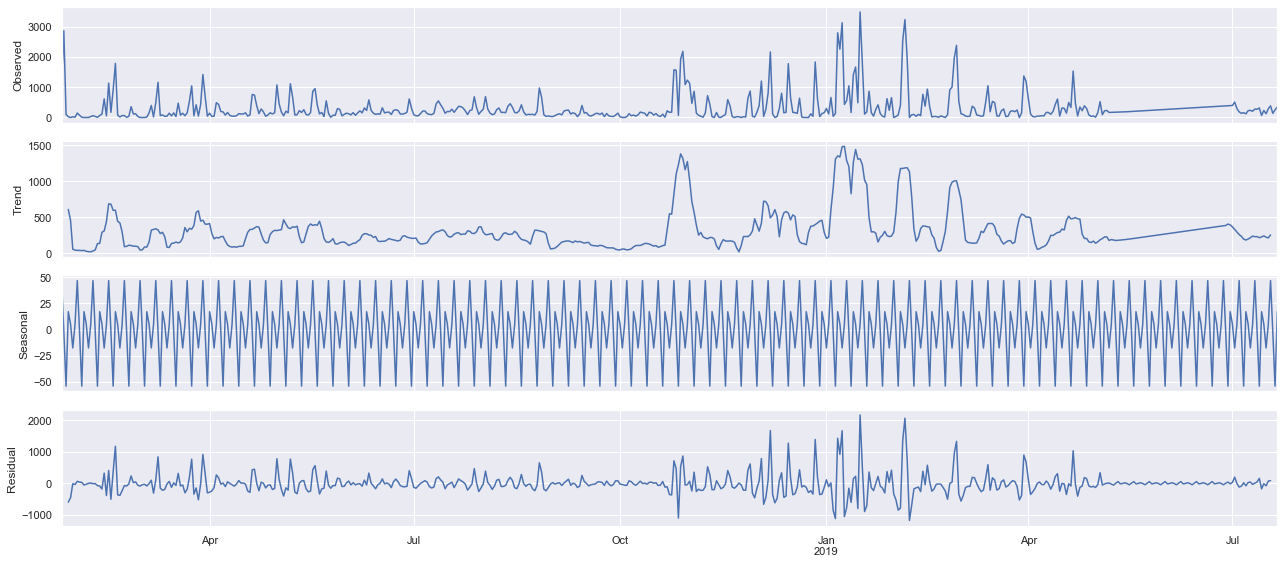

In [89]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(power_kw, model='additive')
fig = decomposition.plot()
plt.show()

the plot above clearly shows that the power is unstable, along with its obvious seasonality.

# 4.Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

#### Parameter Selection for the ARIMA Time Series Model

In [90]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [91]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(power_kw,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8404.339649304478
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8163.640685178391
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:8369.747816964542
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7861.330759068935
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8159.154722655199
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:8068.662160968657
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:8024.804283163006
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7862.077918982842
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8151.732291283872
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:7952.255274205131
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:8176.359410353619
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:7699.092196559055
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7970.497913060738
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:7885.32187713967
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:7879.598063733186
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7698.88321503299
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8214.749292192784
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8009.526611739365
ARIMA(0, 1, 

In [92]:
mod = sm.tsa.statespace.SARIMAX(power_kw,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4749      0.026     18.302      0.000       0.424       0.526
ma.L1         -0.9794      0.010    -97.944      0.000      -0.999      -0.960
ar.S.L12       0.0315      0.030      1.037      0.300      -0.028       0.091
ma.S.L12      -1.0003      0.026    -38.576      0.000      -1.051      -0.949
sigma2      1.572e+05   1.64e-07    9.6e+11      0.000    1.57e+05    1.57e+05


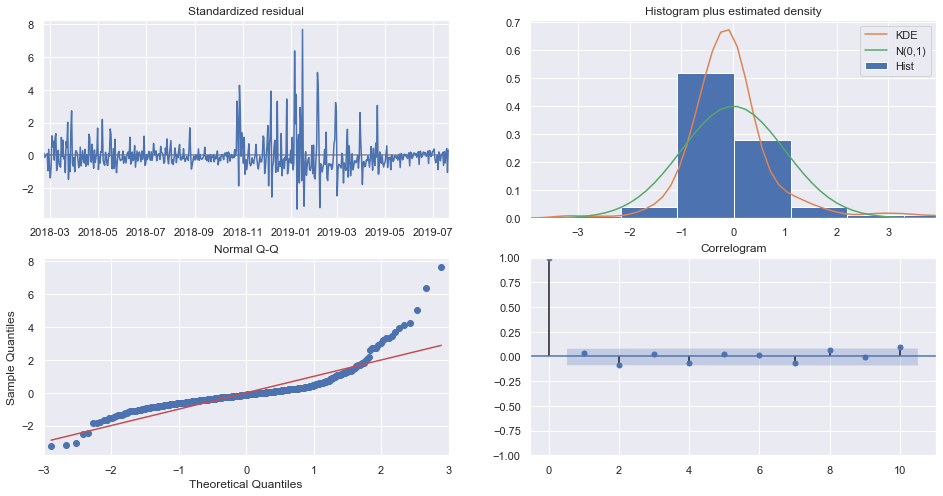

In [93]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted wind power to real wind power of the time series, and  set forecasts to start at 2019-02-22 to the end of the data.

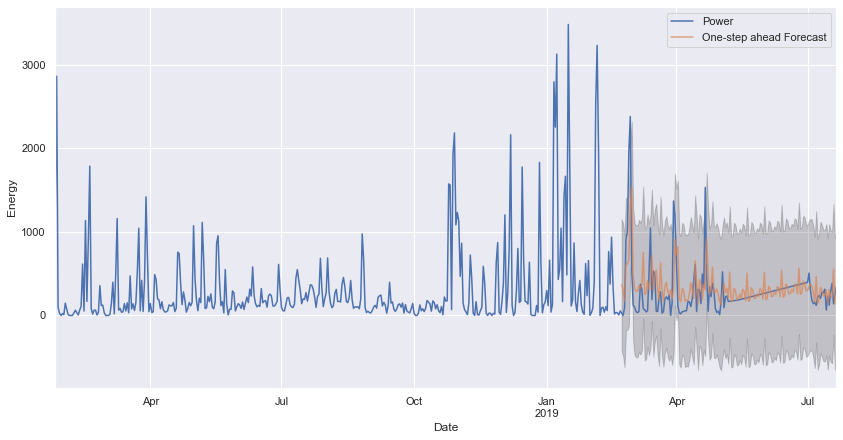

In [94]:
pred = results.get_prediction(start='2019-02-22', dynamic=False)
pred_ci = pred.conf_int()

ax2 = power_kw['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax2, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax2.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax2.set_xlabel('Date')
ax2.set_ylabel('Energy')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, the forecasts align with the true values, showing an downward trend starts at the summer season.

In [95]:
y_forecasted = pred.predicted_mean
y_truth = power_kw['2019-02-22':]
y_truth = y_truth['Power']
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 84809.57


In [96]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 291.22


In [97]:
power_kw.describe()

,Power
count,543.000000
mean,313.437065
std,469.761172
min,0.000000
25%,71.665488
50%,164.595628
75%,329.513432
max,3484.608081


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) shows that the model was able to forecast the average wind power in the test set within 291.22 of the real estimated power. the  wind daily estimated power range from around 0 to over 3500. this is a pretty good model so far.

## Producing and visualizing forecasts

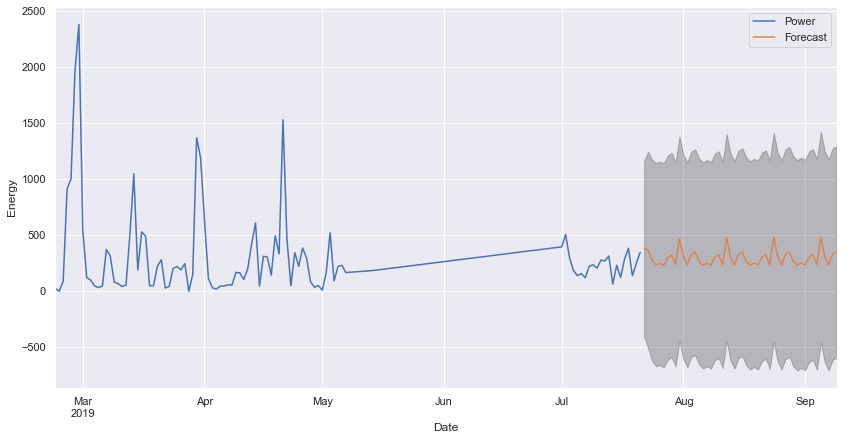

In [98]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

ax = power_kw['2019-02-22':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()

The model clearly captured wind power seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow irregularly as we move further out into the future.unfortunately that was because of data missing and small amount of data.